In [4]:
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scirpy as ir
import numpy as np
import pathlib
import muon as mu
from muon import prot as pt
import os
import numpy as np
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0, "transparent": True}
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import celltypist
from celltypist import models


def tissue_colors():
    tissue_color_dict = {
             'PBMC': '#d6616b',
             'BM': '#cedb9c',
             'LN': '#8c6d31',
             'SPL': '#393b79'}
    return tissue_color_dict

overload = False
if overload == True:
    output_dir='figures/overload'
else:
    output_dir = "figures/no_overload"
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
output_suffix = ""
output_formats = [".png", ".svg"]
sc.settings.figdir = output_dir
sc.set_figure_params(dpi_save = 300)
sc.set_figure_params(format = 'png')
def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None
donor = 'TBD6'
data = '/home/michaelswift/repos/tabula-bursa/data/10X'
samples = ['LN', 'SPL', 'PBMC', 'BM']

def load_data(samplenames, data, donor, overload, tenX_output):
    """samplename is a list of samplenames / tissue names, 
    data is where the data were downloaded
    donor is the name of the donor
    all of these info are used to create the file path
    """
    mdatas = []
    for sample in samples:
        if tenX_output == 'raw':
            datapath = '{}/{}_{}/outs/multi/count/raw_feature_bc_matrix/'.format(data, donor, sample)
            print(datapath)
            mdata = mu.read_10x_mtx(datapath)
            mdata['rna'].obs['tissue'] = sample
            mdatas.append(mdata)
            
        if tenX_output == 'filtered':
            datapath = '{}/{}_{}/outs/per_sample_outs/{}_{}/count/sample_feature_bc_matrix/'.format(data, donor, sample, donor ,sample)
            print(datapath)
            
            mdata = mu.read_10x_mtx(datapath)
            mdata['rna'].obs['tissue'] = sample
            mdatas.append(mdata)
            
    adatas = []
    for mdata in mdatas:
        adata = mdata['rna']
        adatas.append(adata)
    if overload == True:
        analysis = "with_overload"
    else:
        analysis = "without_overload"
    if overload:
    # hard coded number of samples right now
        adata = adatas[0].concatenate(adatas[1], adatas[2], adatas[3], adatas[4], adatas[5], adatas[6], adatas[7])
    else:
        adata = adatas[0].concatenate(adatas[1], adatas[2], adatas[3])
    return adata

def perform_qc(adata):    
    # calculate qc metrics
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    #adata = adata[:,~adata.var.index.str.contains('HSP|DNAJ')]
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)
    sc.pl.highest_expr_genes(adata,save='prefilter')
    # plot qc metrics
    sc.pl.violin(adata, ['n_genes_by_counts', 'log1p_total_counts', 'total_counts'], stripplot=False, multi_panel=True, save='prefilter')
    # cell filter
    sc.pp.filter_cells(adata, min_counts=500)
    sc.pp.filter_cells(adata, max_counts=80000)
    adata = adata[adata.obs['pct_counts_mt'] < 9]
    # plot results of filtering
    sc.pl.violin(adata, ['n_genes_by_counts', 'log1p_total_counts', 'total_counts'], stripplot=False, multi_panel=True, save='postfilter')
    sc.pl.highest_expr_genes(adata, save='postfilter')
    return adata

In [5]:
def cluster(adata, batch_correct=False, batch_key='tissue'):
    sc.pp.pca(adata)
    if batch_correct == True:
        sce.pp.bbknn(adata, batch_key=batch_key)
    else:
        sc.pp.neighbors(adata, n_neighbors=20)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.2)
    sc.pl.umap(adata, color = 'batch')
    return adata


def _merge_adata_vdj(vdj, adata):
    # construct merge columns
    adata.obs['cb_index']=adata.obs.index
    adata.obs['cb'] = adata.obs['cb_index'].str.split('-', expand=True)[0]
    adata.obs['cb_sample_id'] = adata.obs['cb'].astype(str) + '_' + adata.obs['tissue'].astype(str)
    vdj['cb_sample_id'] = vdj['cb'] + '_' + vdj['sample_id']
    # PBL vs PBMC
    vdj['cb_sample_id'] = vdj['cb_sample_id'].str.replace('PBL', 'PBMC')
    print(vdj.shape[0], "vdj / cbs")
    print(vdj.drop_duplicates('cb_sample_id').shape[0], "single vdj with single cb")
    print('dropping multiple vdj cbs')
    vdj = vdj.drop_duplicates('cb_sample_id')
    print('merging vdjs gex')
    merged = pd.merge(adata.obs, vdj, left_on='cb_sample_id', right_on='cb_sample_id')
    print(merged.shape[0], "cells after merging VDJs")
    merged.set_index('cb_index', inplace=True)
    adata = adata[adata.obs.index.isin(merged.index)]
    adata.obs = merged
    return adata

In [6]:
adata = sc.read_h5ad('../../data/processed_h5ad/filtered_bcells.h5ad')

In [7]:
adata = adata[adata.obs['true_b_cell'] == True]

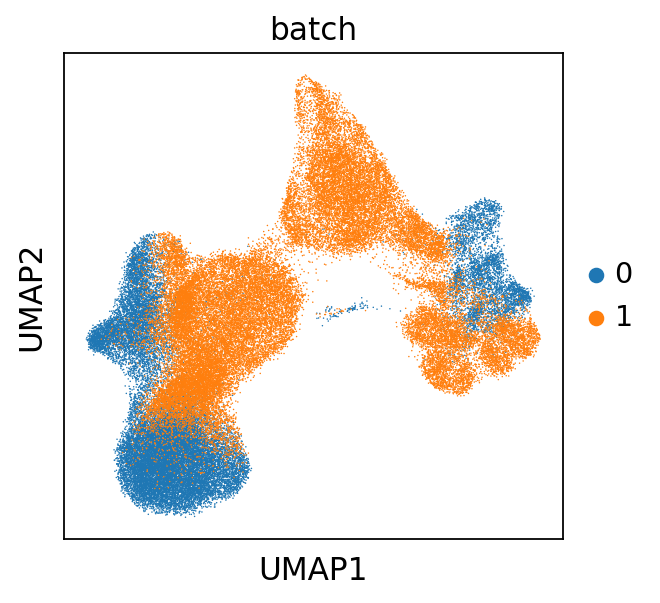

In [8]:
adata = cluster(adata, batch_correct=True, batch_key='tissue')

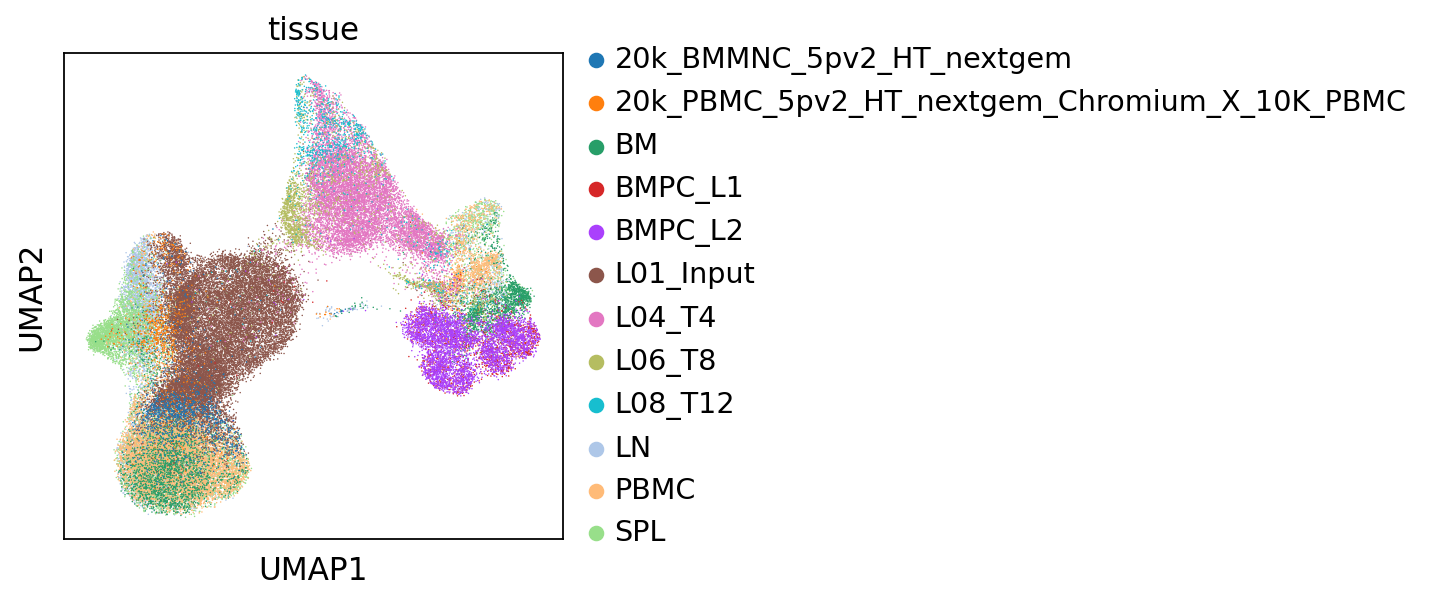

In [9]:
sc.pl.umap(adata, color = 'tissue')

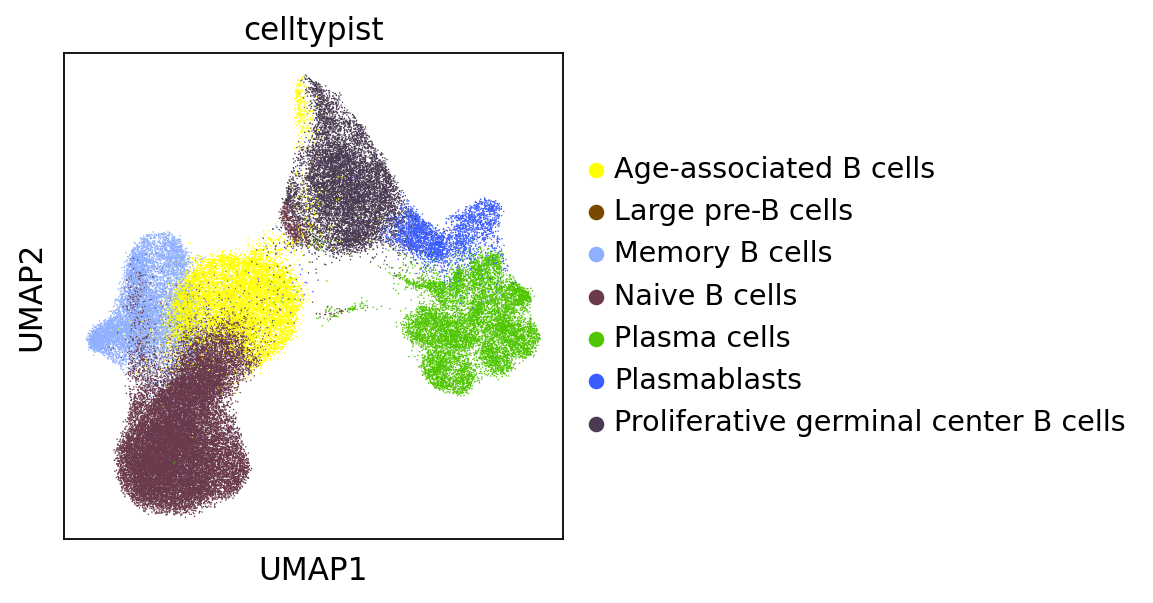

In [10]:
sc.pl.umap(adata, color = 'celltypist')

Text(0, 0.5, 'sample_id')

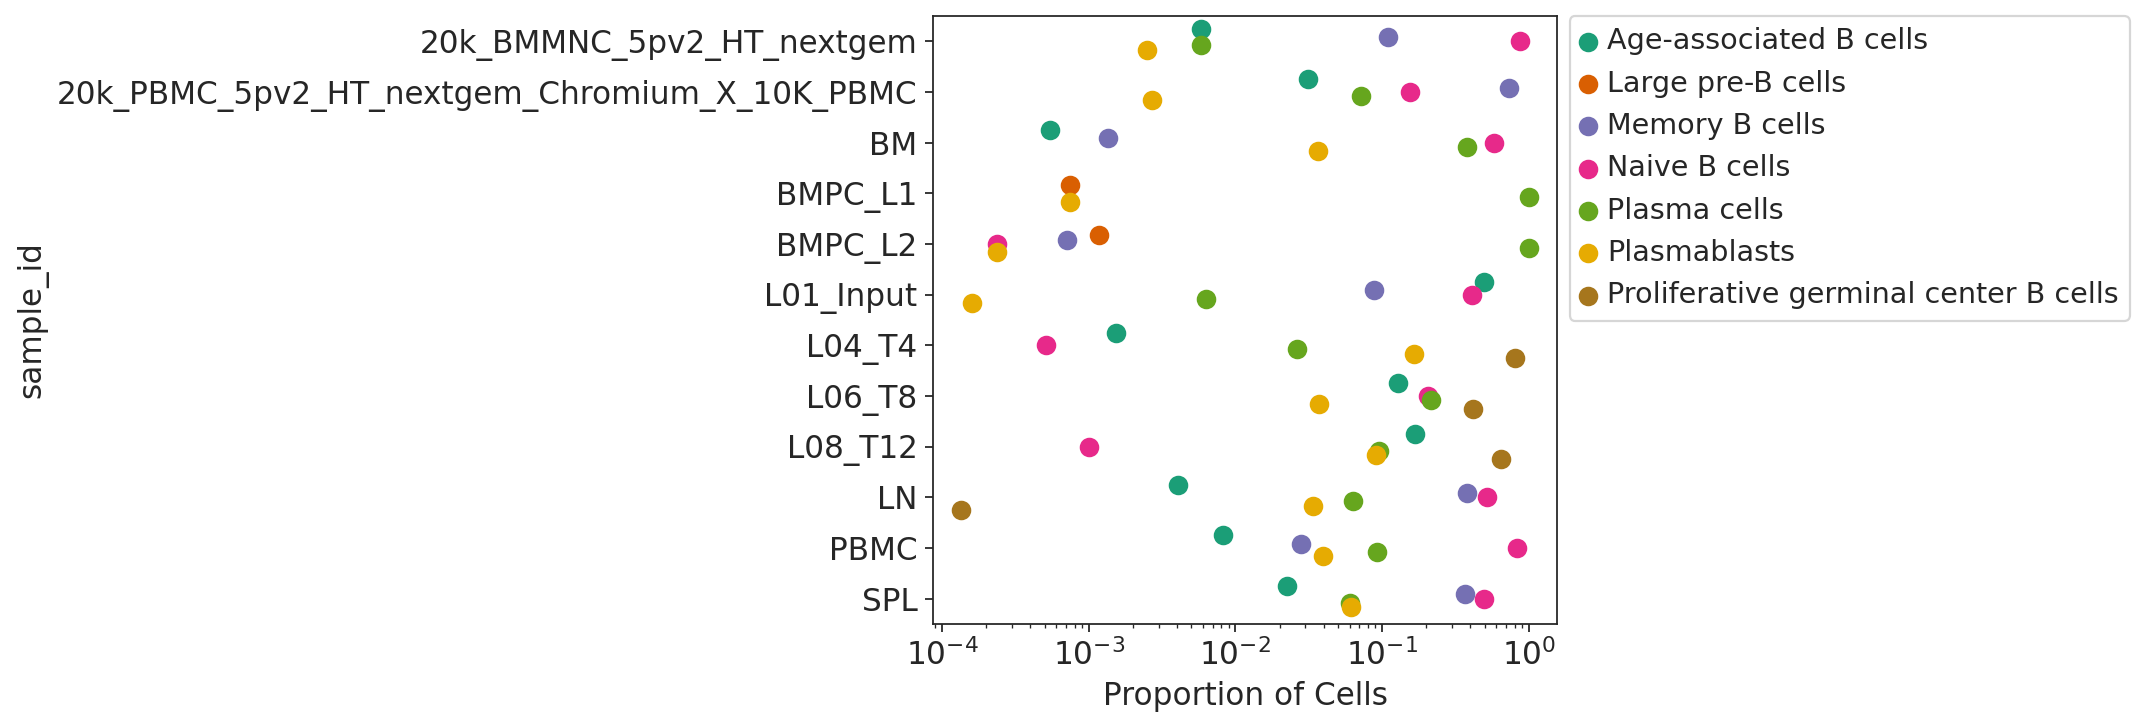

In [11]:
group = "tissue"
label = "celltypist"
color = label
data = pd.DataFrame(adata.obs.groupby([group])[label].value_counts(normalize=True))
data.columns = ["dummy"]
data.reset_index(inplace=True)
data.columns = ["sample_id", "celltype", "proportion"]
sns.axes_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(5,5))

sns.pointplot(
    y="sample_id",
    x="proportion",
    hue="celltype",
    data=data,join = False, dodge=0.5, palette='Dark2')

plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xlabel("Proportion of Cells")
plt.ylabel("sample_id")

/tmp/ipykernel_21040/2991439092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data.celltype = sub_data.celltype.cat.remove_unused_categories()


Text(0, 0.5, 'sample_id')

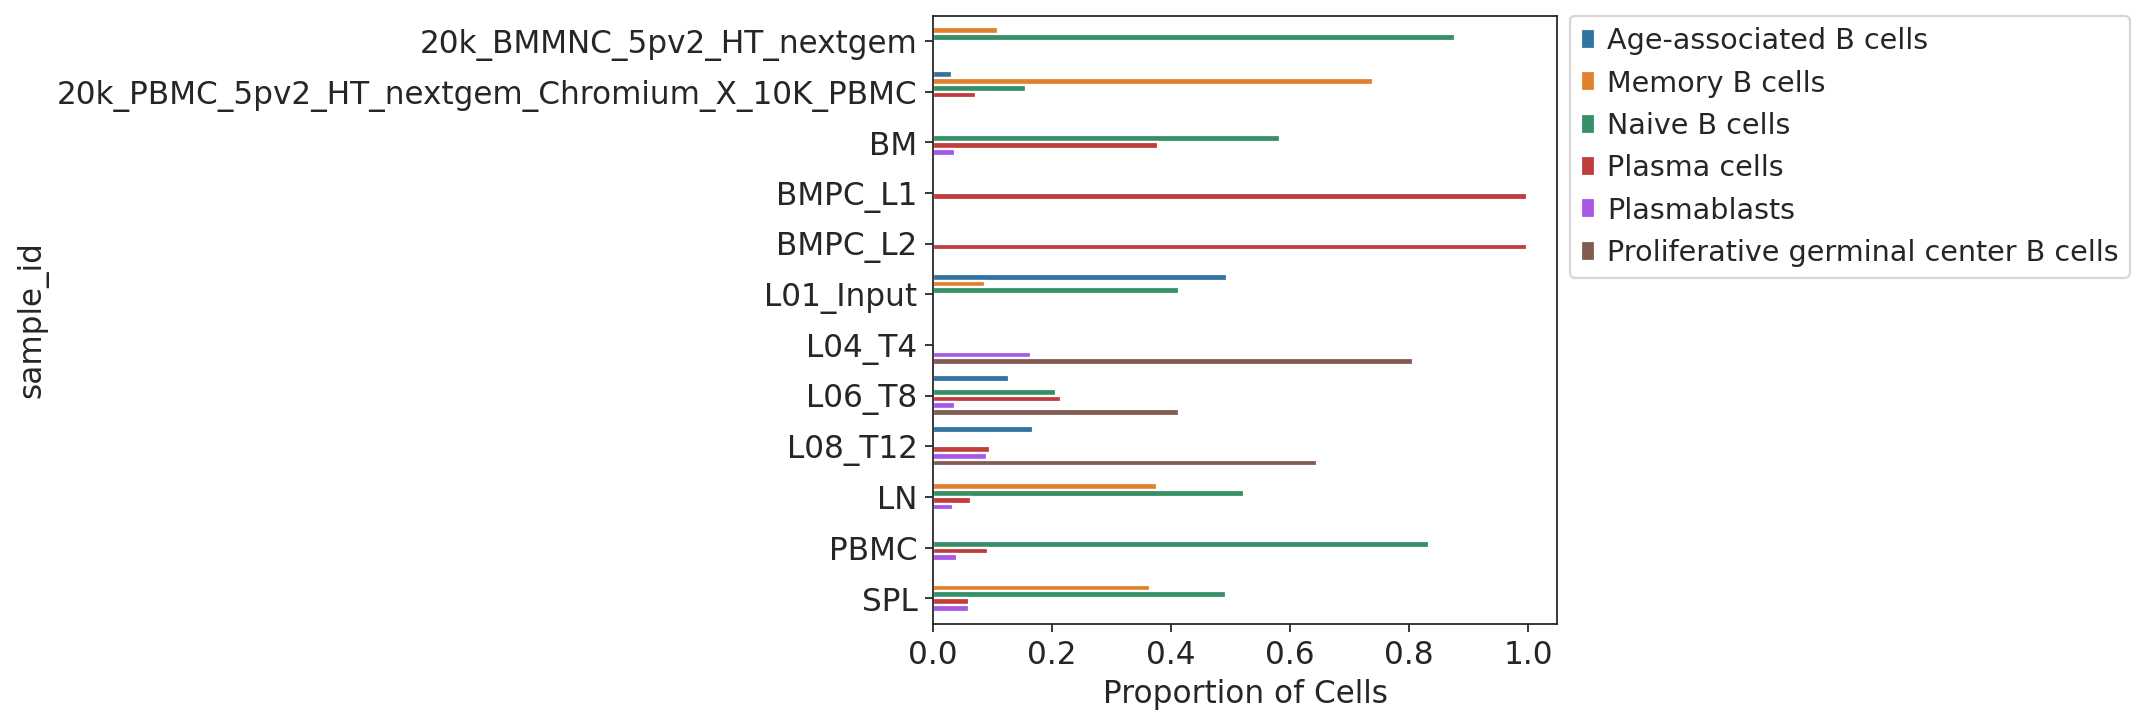

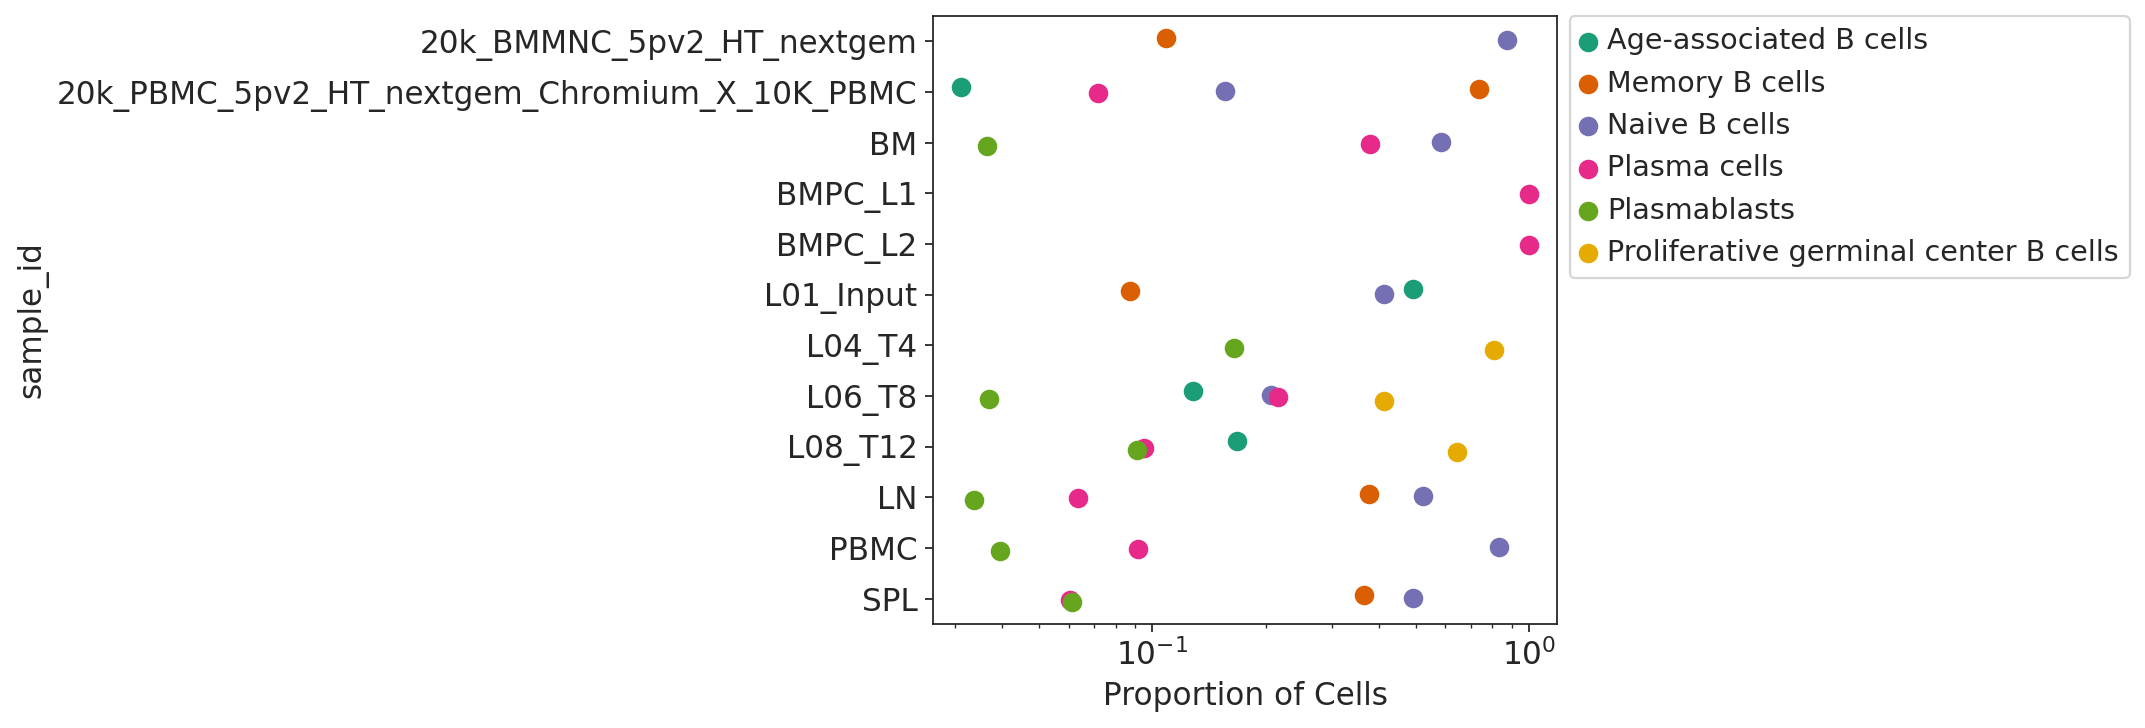

In [12]:
sub_data = data[data.proportion > 0.03]
sub_data.celltype = sub_data.celltype.cat.remove_unused_categories()
sns.axes_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(5,5))

sns.barplot(
    y="sample_id",
    x="proportion",
    hue="celltype",
    data=sub_data,)

#plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xlabel("Proportion of Cells")
plt.ylabel("sample_id")


fig, ax = plt.subplots(1, 1, figsize=(5,5))

sns.pointplot(
    y="sample_id",
    x="proportion",
    hue="celltype",
    data=sub_data,join = False, dodge=0.2, palette='Dark2')

plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xlabel("Proportion of Cells")
plt.ylabel("sample_id")


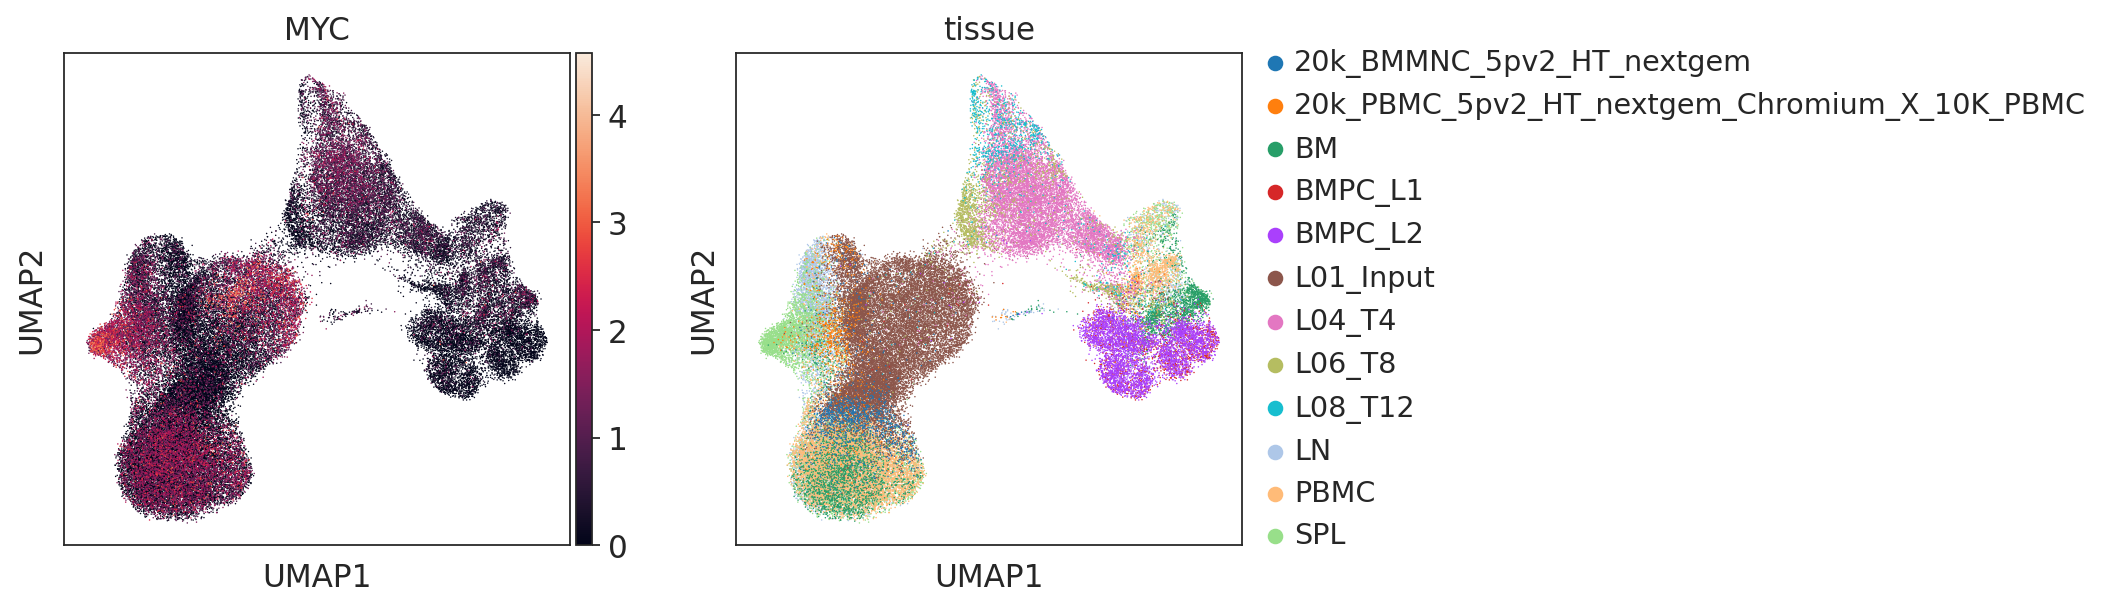

In [15]:
sc.pl.umap(adata, color = ['MYC', 'tissue'])

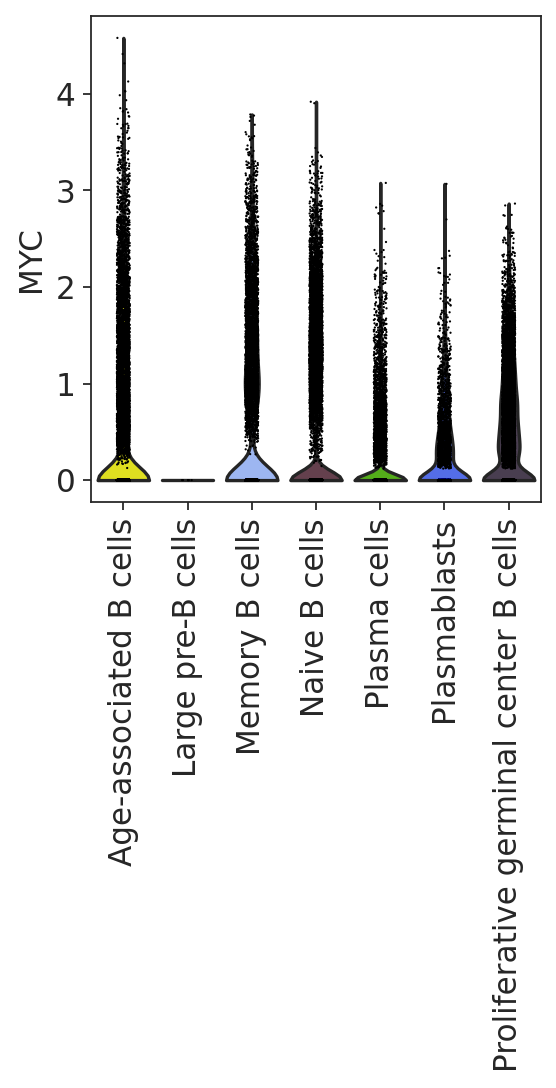

In [18]:
sc.pl.clustermap(adata, keys=['MYC'], groupby='celltypist', rotation=90)

In [19]:
sc.tl.rank_genes_groups(adata, groupby='celltypist')

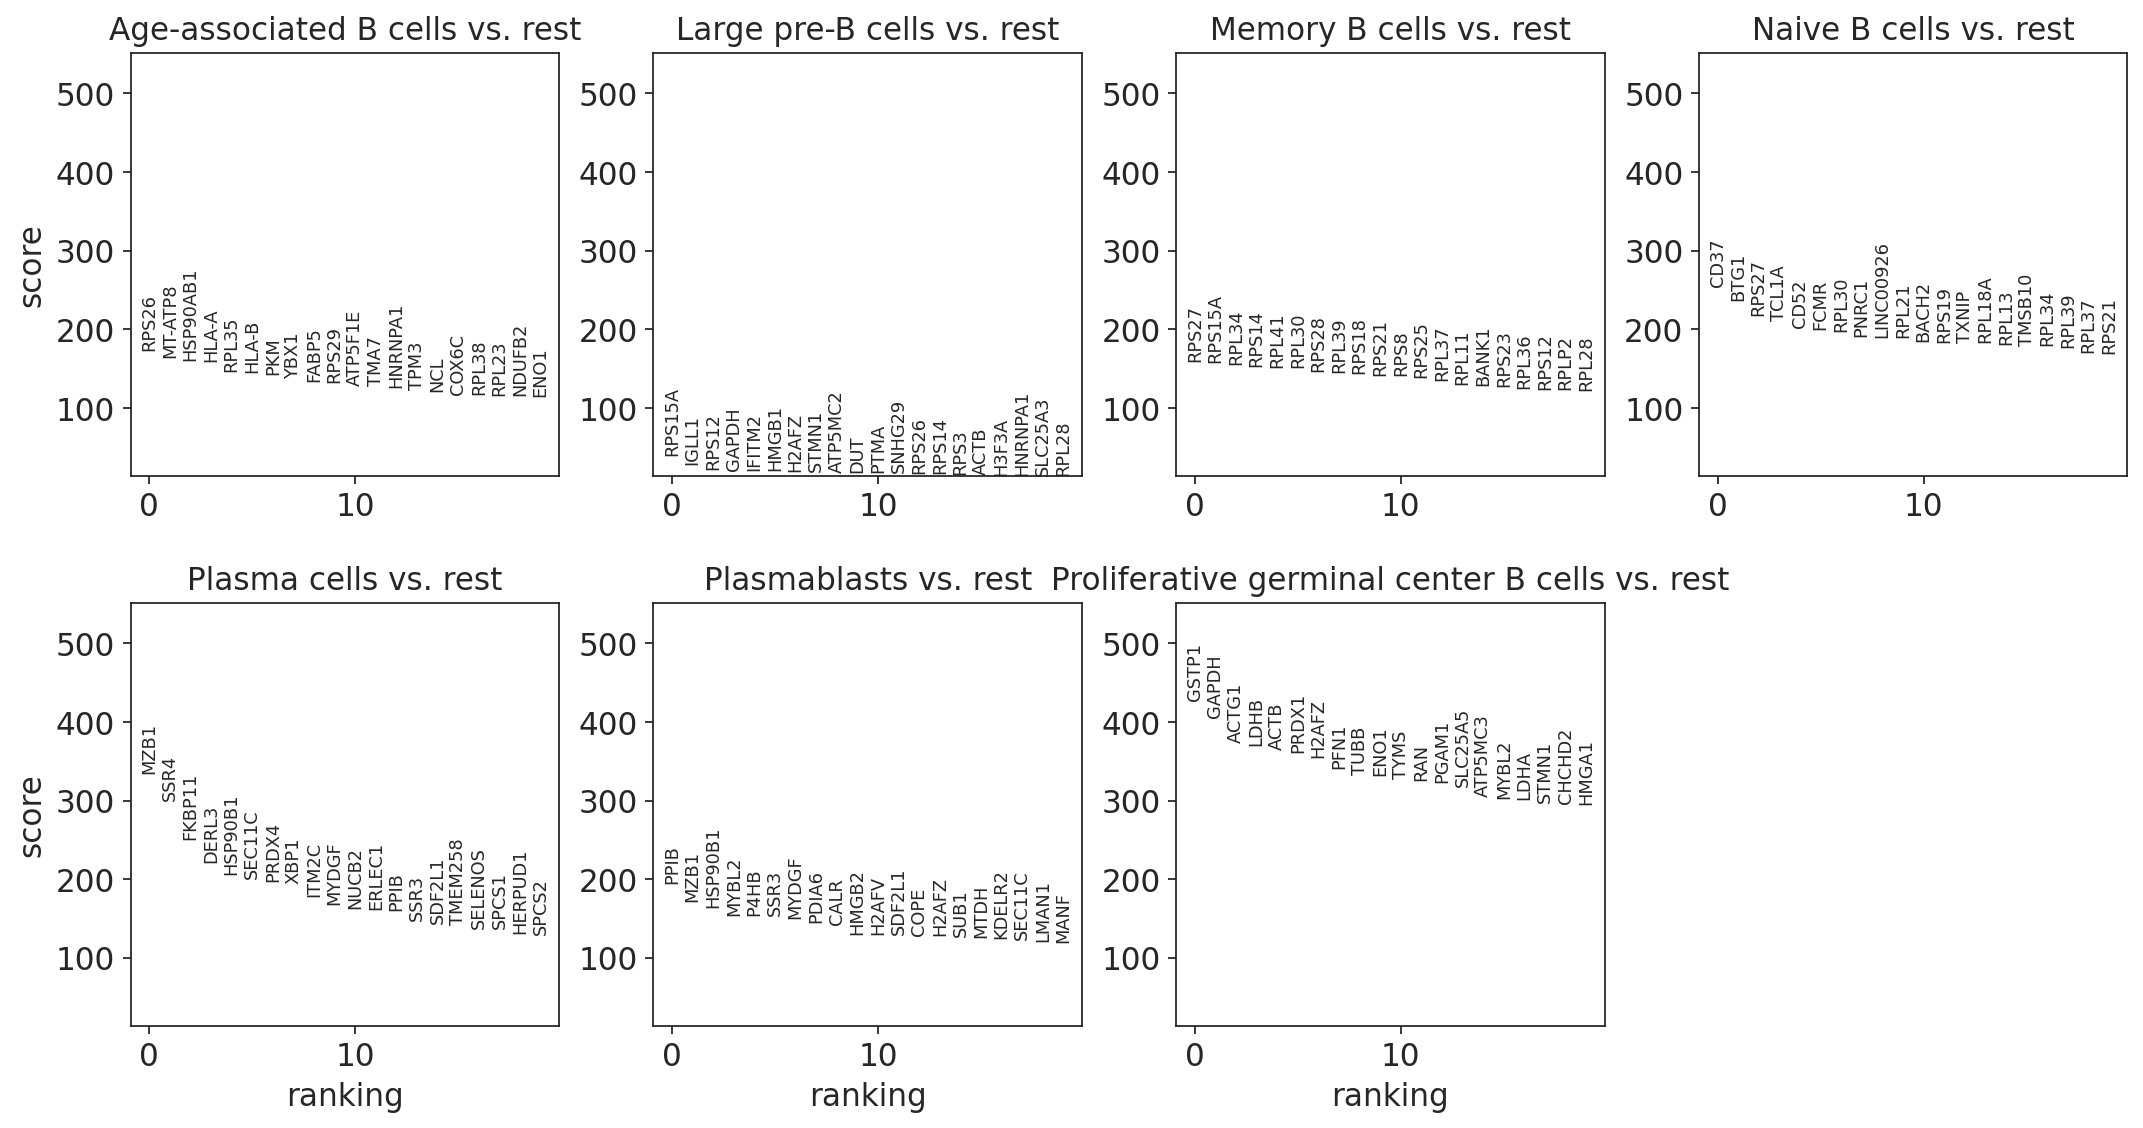

In [20]:
sc.pl.rank_genes_groups(adata)

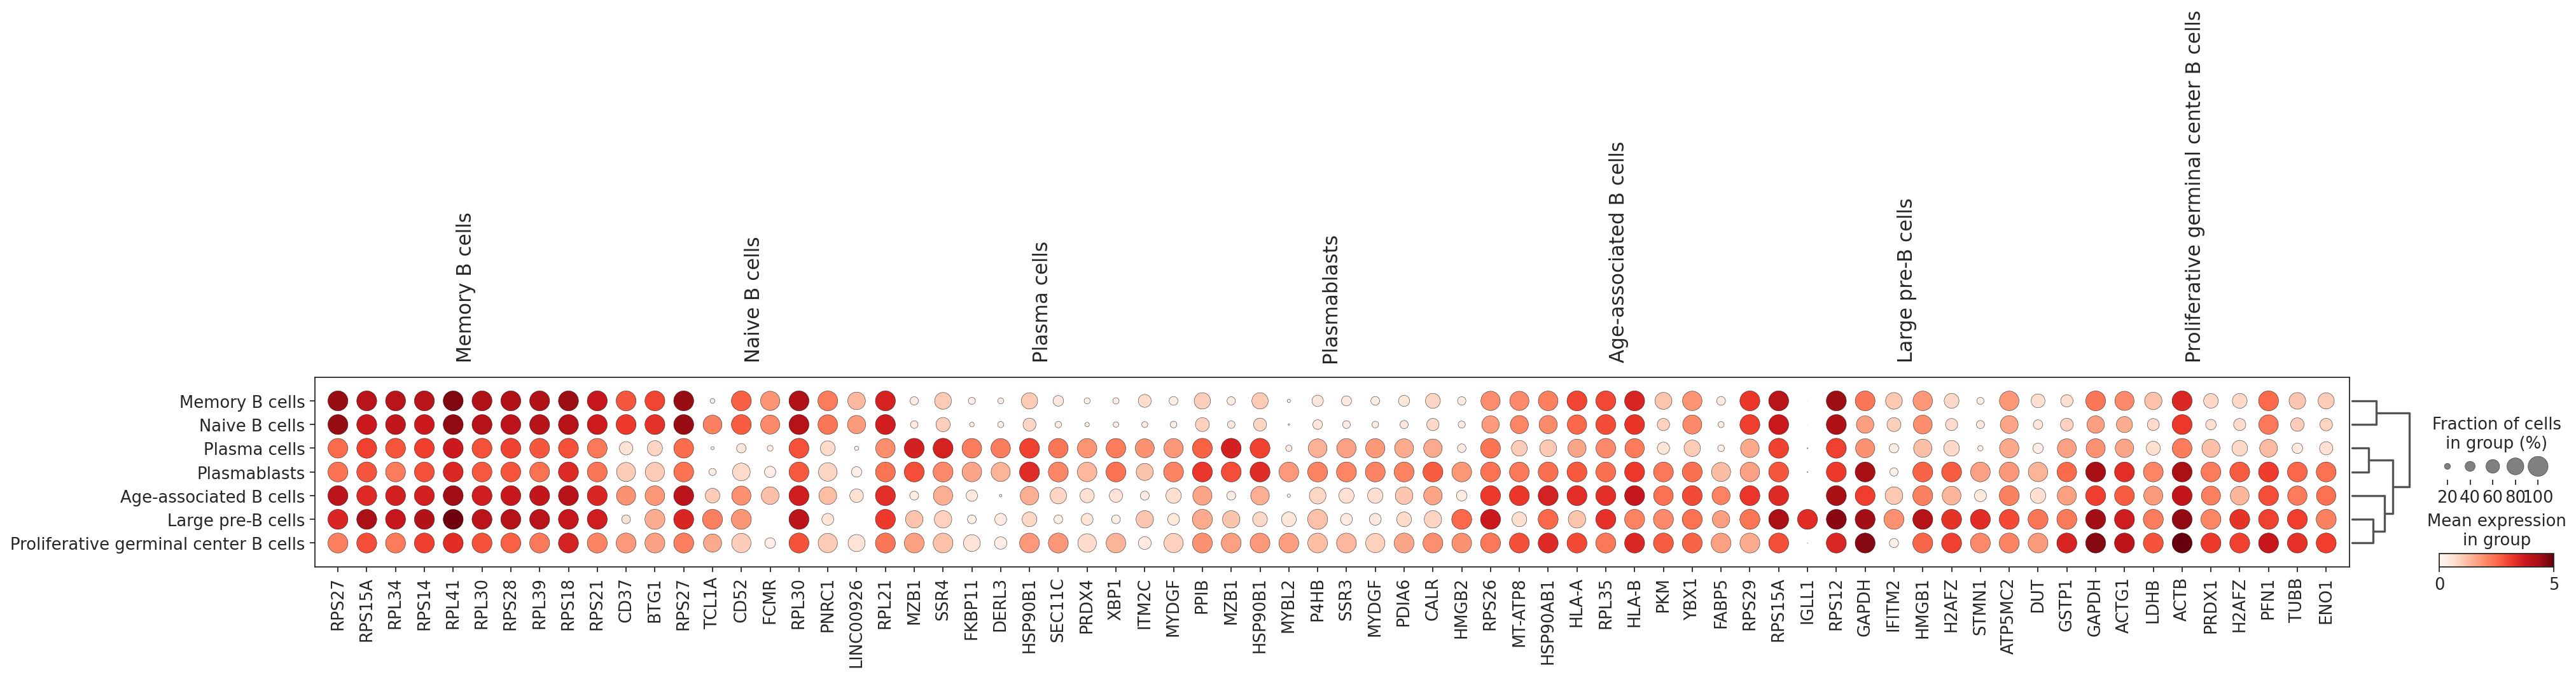

In [22]:
sc.pl.rank_genes_groups_dotplot(adata)

In [29]:
# understand the failure modes:
    # dead cells
    # they look dead bc
    # there's these age-associated B cells but are they really?
    # the bone marrow seems stressed?
    # what kinds of artefacts exist